In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = 'data/MNIST/'
test_csv = f'{PATH}test.csv'
train_csv = f'{PATH}train.csv'

In [6]:
def show_images(image_array):
    plt.imshow(np.concatenate(np.concatenate(image_array, 0), 1), cmap='gray')

In [7]:
class MyImageDataset(Dataset):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
        """
        data_file = pd.read_csv(csv_file)
        self.images = data_file.drop('label', 1).values
        self.images = self.images / 255
        self.images = self.images.reshape(-1, 1, 28, 28)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.images[idx]

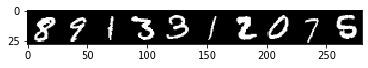

In [8]:
# Test the MyImageDataset class
image_dataset = MyImageDataset(train_csv)
# image_dataset[10:20].shape
show_images(image_dataset[10:20])

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=5),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=5),
            nn.Sigmoid()            
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
# Define hyperparameters
num_epochs = 10
batch_size = 256
weight_decay = 1e-4
learning_rate = 1e-3

In [11]:
image_dataloader = DataLoader(torch.Tensor(image_dataset).double().cuda(), batch_size=batch_size, shuffle=True)

In [26]:
# Initialise the model
autoencoder = AutoEncoder().cuda()

# Use a Mean Squared Error loss
distance = nn.MSELoss()

# Use the Adam Optimiser
optimiser = Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [27]:
# Train the model
for epoch in range(num_epochs):
    for data in image_dataloader:
        # Forward
        autoencoder.double()
        output = autoencoder(data)
        loss = distance(data, output)
        # Backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))

epoch [1/10], loss:0.0835
epoch [2/10], loss:0.0704
epoch [3/10], loss:0.0835
epoch [4/10], loss:0.0783
epoch [5/10], loss:0.0750
epoch [6/10], loss:0.0731
epoch [7/10], loss:0.0694
epoch [8/10], loss:0.0606
epoch [9/10], loss:0.0514
epoch [10/10], loss:0.0474


## Test the model

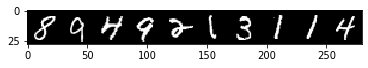

In [14]:
# Show the test images
test_images = image_dataset[30:40]
show_images(test_images)

### Test Output Image

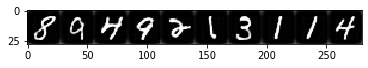

In [15]:
# Get the output
output_images = autoencoder(torch.from_numpy(test_images).cuda())
# Show Output Images
show_images(output_images.cpu().detach().numpy())

### Test Encoding / Decoding

In [16]:
# Get encoded codes
output_codes = autoencoder.encoder(torch.from_numpy(test_images).cuda())
output_codes.shape

torch.Size([10, 1, 20, 20])

In [17]:
# Decode the codes
decoded_images = autoencoder.decoder(output_codes)
decoded_images.shape

torch.Size([10, 1, 28, 28])

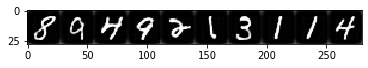

In [18]:
# Show the decoded images
show_images(decoded_images.cpu().detach().numpy())